In [1]:
from datetime import datetime
import pandas as pd
import requests
import json

In [2]:
def get_btcprice(ticker, _max):
  url = ('https://api.coingecko.com/api/v3/coins/')+ticker+('/market_chart?vs_currency=usd&days=')+_max
  r = requests.get(url)
  r2 = json.loads(r.text)
  return r2


In [5]:
def reshape_pricedata(r2):
  s = pd.DataFrame(r2['prices'])
  s.columns = ['date', 'prices']
  date = []

  for i in s['date']:
    tsdate = int(i/1000)
    loc = datetime.utcfromtimestamp(tsdate)
    date.append(loc)

  s.index = date
  del s['date']
  return s

In [6]:
r2 = get_btcprice('bitcoin', 'max')
btcprice = reshape_pricedata(r2)
btcprice.head()

,prices
2013-04-28,135.30
2013-04-29,141.96
2013-04-30,135.30
2013-05-01,117.00
2013-05-02,103.43


In [54]:
# SMA
def calc_sma(price_data, terms=5, index=True):
    rolling_means = []
    for i in range(len(price_data)):
        data = price_data['prices'][i-terms:i]
        sum_ = 0
        if data.empty:
            pass
        else:
            for e in data:
                sum_ += e
            rolling_terms = [data.index[-1], sum_/terms]
            rolling_means.append(rolling_terms)

    # データフレームのindexをそのままにしておく
    if index:
        return pd.DataFrame(rolling_means, columns=['date', 'prices'])
    #データフレームのINDEXを日付データにする
    else:
        df = pd.DataFrame(rolling_means)
        df.index = df[0].values
        df = df.drop(0, axis=1)
        df.columns = ['prices']
    return df


# 5日移動平均線を計算する
SMA5 =calc_sma(btcprice, terms=5, index=True)
# 25日移動平均線を計算する
SMA25 =calc_sma(btcprice, terms=25, index=True)

In [55]:
# EMA
def calc_ema(price_data, terms, index=True):
    # 移動平均を計算する
    sma = calc_sma(price_data=price_data, terms=terms, index=False)
    # 指数移動平均の計算に使うαを求める
    a = 2 / (terms + 1)

    # 指数移動平均を計算する
    ema = []
    for i in range(len(sma)+1):
        if i==0:
            ema_data = float(sma.iloc[0].values)
            ema.append([sma.index[0], ema_data])
        else:
            ema_data = ema[i-1][1] + a*(float(price_data.iloc[(i)+(terms-1)].values)-ema[i-1][1])
            ema.append([price_data.index[terms-1+i], ema_data])

    # 出力形式を変える
    if index:
        return pd.DataFrame(ema, columns=['date', 'prices'])
    else:
        df = pd.DataFrame(ema)
        df.index = df[0].values
        df = df.drop(0, axis=1)
        df.columns = ['prices']
    return df

# 5日指数移動平均線を計算する
ema5 = calc_ema(price_data=btcprice, terms=5, index=True)
# 10日指数移動平均線を計算する
ema10 = calc_ema(price_data=btcprice, terms=10, index=True)

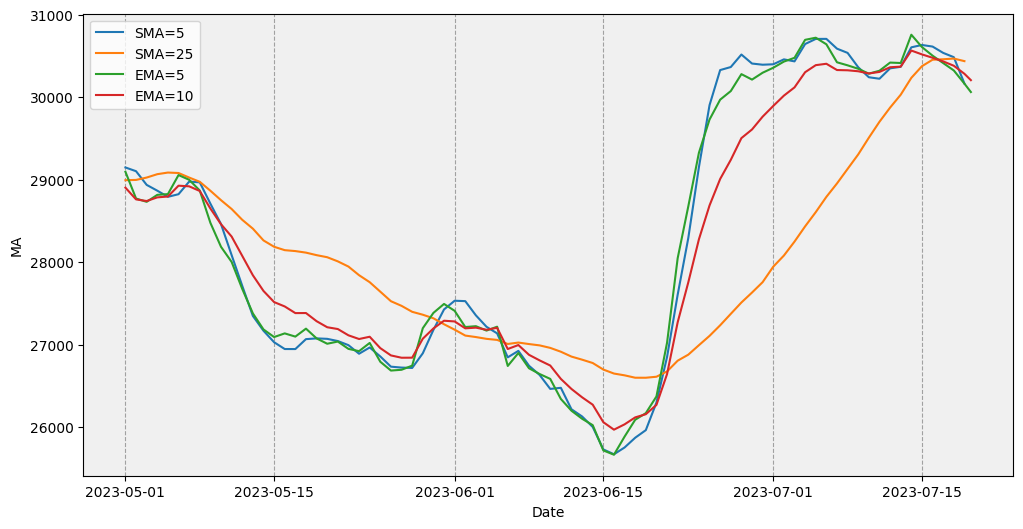

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# グラフのサイズを設定（オプション）
plt.figure(figsize=(12, 6))

# 出力したい期間を限定する
SMA5_onwards = SMA5[SMA5['date'] >= '2023-05-01']
SMA25_onwards = SMA25[SMA25['date'] >= '2023-05-01']
ema5_onwards = ema5[ema5['date'] >= '2023-05-01']
ema10_onwards = ema10[ema10['date'] >= '2023-05-01']

# 移動平均の折れ線グラフをプロット
plt.plot(SMA5_onwards['date'], SMA5_onwards['prices'], label='SMA=5')
plt.plot(SMA25_onwards['date'], SMA25_onwards['prices'], label='SMA=25')
plt.plot(ema5_onwards['date'], ema5_onwards['prices'], label='EMA=5')
plt.plot(ema10_onwards['date'], ema10_onwards['prices'], label='EMA=10')

# グラフの背景色を設定
plt.gca().set_facecolor('#f0f0f0')

# X軸に区切り線を追加
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.7)

# ラベルやタイトルを設定
plt.xlabel('Date')
plt.ylabel('MA')
plt.legend()

# グラフを表示
plt.show()